In [1]:
import numpy as np
from keras import layers
from keras.layers import Input,Add,Dense,Activation,ZeroPadding2D,BatchNormalization,Flatten,Conv2D,AveragePooling2D,MaxPooling2D,GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.utils.np_utils import to_categorical   
from keras.applications.imagenet_utils import preprocess_input
from keras.initializers import glorot_uniform
from keras.optimizers import SGD
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

import keras.backend as K

import tarfile
import matplotlib.pyplot as plt
import pickle

In [2]:
def extract(path,file):
  tf=tarfile.open(path+rarfile) #one-time run to extract to dir
  tf.extractall()
  tf.close()

In [3]:
def unpickle(file):
  with open(file,"rb") as fo:
    dict=pickle.load(fo,encoding='bytes')
  return dict

In [4]:
def crop(img):
  img=np.expand_dims(img,axis=0)
  img=ZeroPadding2D((4,4))(img)
  img=np.squeeze(img,axis=0)

  #random pixel selection
  h=np.random.randint(8)
  w=np.random.randint(8)

  img=img[h:h+32, w:w+32,:]


  return img


In [5]:
def load_cifar(final, negatives=False):
  metadict=unpickle(final+"batches.meta")
  label_names=metadict[b'label_names']
  label_names=np.array(label_names)

  training_data=None
  training_labels=[]
  

  for i in range(1,6):
    training_data_dict=unpickle(final+"data_batch_{}".format(i))
    if i==1:
      training_data=training_data_dict[b'data']
    else:
      training_data=np.vstack((training_data,training_data_dict[b'data']))
    training_labels += training_data_dict[b'labels']

  training_data=training_data.reshape(len(training_data),3,32,32)


  if negatives:
    training_data=training_data.transpose(0,2,3,1).astype(np.float32)
  else:
    training_data = np.rollaxis(training_data, 1, 4)
  training_labels=np.array(training_labels)

  validation_data=training_data[45000:50001]
  training_data=training_data[0:45000]
  validation_labels=training_labels[45000:50001]
  training_labels=training_labels[0:45000]
  


  test_data=None
  test_labels=[]

  test_data_dict=unpickle(final+"test_batch")


  test_data=test_data_dict[b'data']
  test_labels = test_data_dict[b'labels']
  

  test_data=test_data.reshape(len(test_data),3,32,32)

  if negatives:
    test_data=test_data.transpose(0,2,3,1).astype(np.float32)
  else:
    test_data=np.rollaxis(test_data,1,4)

  test_labels=np.array(test_labels)
  
  return (training_data, training_labels, validation_data, validation_labels, test_data, test_labels, label_names)

In [6]:
path="/content/drive/My Drive/Colab Notebooks/"
rarfile="cifar-10-python.tar.gz"
final="/content/cifar-10-batches-py/"

extract(path,rarfile)    #one time use
X_train_orig, Y_train_orig, X_valid_orig, Y_valid_orig, X_test_orig, Y_test_orig ,labels=load_cifar(final)

print("Train data: ", X_train_orig.shape)
print("Train labels: ", Y_train_orig.shape)
print("Validation data: ", X_valid_orig.shape)
print("Validation labels: ", Y_valid_orig.shape)
print("Test data: ", X_test_orig.shape)
print("Test labels: ", Y_test_orig.shape)
print("Label names: ", labels.shape)

Train data:  (45000, 32, 32, 3)
Train labels:  (45000,)
Validation data:  (5000, 32, 32, 3)
Validation labels:  (5000,)
Test data:  (10000, 32, 32, 3)
Test labels:  (10000,)
Label names:  (10,)


In [7]:
#Normalization
X_train=X_train_orig.astype("float32")
X_valid=X_valid_orig.astype("float32")
X_test=X_test_orig.astype("float32")
mean=np.mean(X_train)
std=np.std(X_train)

#can divided by 255 (max value of color channel)
#X_train/=255
#X_valid/=255
#X_test/=255

#alternate
X_train=(X_train-mean)/(std+1e-7)
X_valid=(X_valid-mean)/(std+1e-7)
X_test=(X_test -mean)/(std+1e-7)

In [8]:
Y_train=to_categorical(Y_train_orig,10)
Y_valid=to_categorical(Y_valid_orig,10)
Y_test=to_categorical(Y_test_orig,10)
#print(Y_train[10:30])
#print(Y_train_orig[10:30])

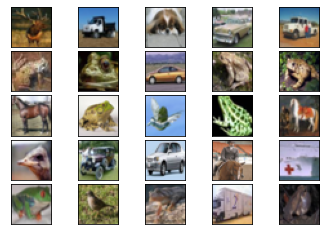

In [9]:
num_plot = 5
f, ax = plt.subplots(num_plot, num_plot)
for m in range(num_plot):
    for n in range(num_plot):
         idx = np.random.randint(0, X_train.shape[0])
         ax[m, n].imshow(X_train_orig[idx])
         ax[m, n].get_xaxis().set_visible(False)
         ax[m, n].get_yaxis().set_visible(False)
f.subplots_adjust(hspace=0.1)
f.subplots_adjust(wspace=0)
plt.show()

In [14]:
#data_aug
datagen=ImageDataGenerator(horizontal_flip=True, preprocessing_function=crop)

datagen.fit(X_train)

In [15]:
def identity_block(X, f, filters, stage, block):
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)
    
    return X

In [16]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    # First component of main path by default padding is taken valid
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)
    
    
    return X

In [17]:
def ResNet(input_shape = (32, 32, 3), classes = 10, n=1):
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
  
    X = X_input
    
    # first layer
    # output size: 32,32,16
    X = Conv2D(16, (3, 3), strides = (1, 1),padding='same', name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)

    # 2n layers
    # output size: 32,32,64
    X = convolutional_block(X, f = 3, filters = [16, 16, 64], stage = 2, block='a', s = 1)
    for i in range (2*n -1):
      X = identity_block(X, 3, [16, 16, 64], stage=2, block=chr(98+i))

    # 4n layers
    # output size: 16, 16, 128
    X = convolutional_block(X,f=3,filters=[32,32,128],stage=3,block ='a',s=2)
    for i in range(2*n-1):
      X=identity_block(X, 3, [32, 32, 128], stage=3, block=chr(98+i))

    # 6n layers
    # output size: 8, 8, 256
    X = convolutional_block(X,f=3,filters=[64,64,256],stage=4,block ='a',s=2)
    for i in range(2*n-1):
      X=identity_block(X, 3, [64, 64, 256], stage=4, block=chr(98+i))

    # AVGPOOL (≈1 line).
    #output: 1,1,256
    X = AveragePooling2D((8,8), name="avg_pool")(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_regularizer = l2(0.0001), bias_regularizer = l2(0.0001), name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    model = Model(inputs = X_input, outputs = X, name='ResNet')

    return model

In [18]:
model=ResNet(input_shape=(32,32,3), classes=10, n=3) #number of layers=6n+2

In [19]:
sgd=SGD(learning_rate=0.1, momentum=0.9, name='SGD');
model.compile(optimizer = sgd, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [21]:
early=EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=30, mode='auto')
checkpoint=ModelCheckpoint("tmp/checkpoint", monitor='val_accuracy', save_best_only=True, save_weights_only=False, mode='auto')
rlrop=ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=0.0001, patience=10, mode='auto')

In [22]:
hist=model.fit(datagen.flow(X_train,Y_train, batch_size=64), epochs = 200, validation_data=(X_valid, Y_valid), callbacks=[early , checkpoint, rlrop])

Epoch 1/200
704/704 [==============================] - ETA: 0s - loss: 2.4598 - accuracy: 0.1451WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: tmp/checkpoint/assets
704/704 [==============================] - 109s 154ms/step - loss: 2.4598 - accuracy: 0.1451 - val_loss: 2.0243 - val_accuracy: 0.2160
Epoch 2/200
704/704 [==============================] - 108s 153ms/step - loss: 1.8900 - accuracy: 0.2941 - val_loss: 1.6832 - val_accuracy: 0.3854
Epoch 3/200
704/704 [==============================] - 108s 154ms/step - loss: 1.6589 - accur

In [23]:
model1=load_model("tmp/checkpoint")

In [24]:
model1.evaluate(X_train, Y_train)
model1.evaluate(X_valid,Y_valid)
model1.evaluate(X_test,Y_test)

313/313 [==============================] - 3s 9ms/step - loss: 0.3870 - accuracy: 0.9022


[0.38695740699768066, 0.9021999835968018]

In [25]:
model1.save(path+'ResNet.h5')
#saves architecture, weights, training_config(loss, optimizer), the exact state you are training

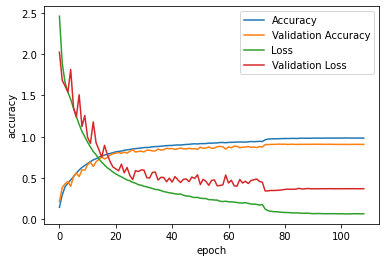

In [26]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(["Accuracy", "Validation Accuracy","Loss","Validation Loss"])
plt.show()

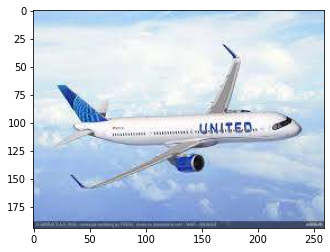

prediction:  b'airplane'


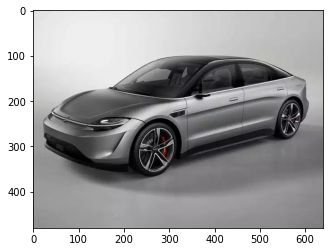

prediction:  b'automobile'


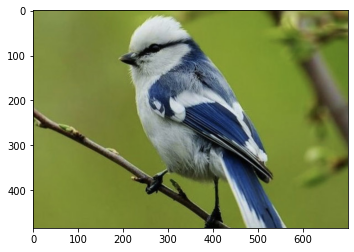

prediction:  b'bird'


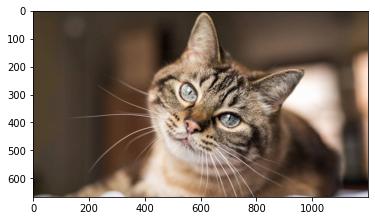

prediction:  b'cat'


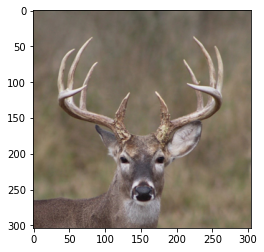

prediction:  b'deer'


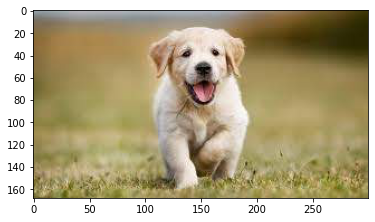

prediction:  b'dog'


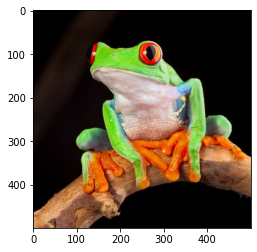

prediction:  b'frog'


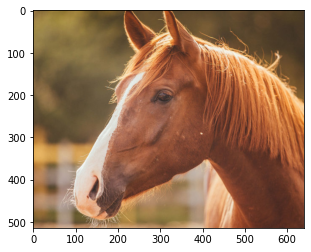

prediction:  b'horse'


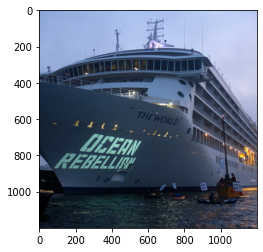

prediction:  b'ship'


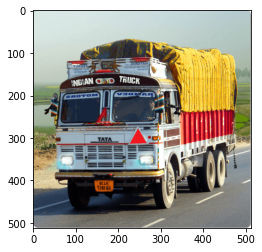

prediction:  b'truck'


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [51]:
def predict(images_path):
  for i in range(len(images_path)):
    u=plt.imread(images_path[i])
    plt.imshow(u) # printing the images
    plt.show()

    img = image.load_img(images_path[i], target_size = (32, 32)) # loading the image and resizing to 32 x 32
    x = image.img_to_array(img) # converting image to array
    x = np.expand_dims(x, axis = 0) # expanding the dimensions
    x = (x - mean) / std # normalization
    prediction = model1.predict(x) # getting the prediction vector
    prediction = np.squeeze(prediction)
    max = np.max(prediction)
    print("prediction: ",labels[prediction.tolist().index(max)]) # printing the label with the highest probability 

images = [path+"cifar 10 preds/plane.jpg",path+"cifar 10 preds/car.jpg", path+"cifar 10 preds/bird.jpg", path+"cifar 10 preds/cat.jpg", path+"cifar 10 preds/deer.jpg", path+"cifar 10 preds/dog.jpg", path+"cifar 10 preds/frog.jpg", path+"cifar 10 preds/horse.jpg", path+"cifar 10 preds/ship.jpg", path+"cifar 10 preds/truck.jpg"]
predict(images)

In [52]:
# printing the confusion matrix and the classification report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print("Labels\n")
print(labels)
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis = 1)
y_test = np.argmax(Y_test, axis = 1)
print("\nConfusion Matrix\n")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report\n")
print(classification_report(y_test, y_pred, target_names=labels))

Labels

[b'airplane' b'automobile' b'bird' b'cat' b'deer' b'dog' b'frog' b'horse'
 b'ship' b'truck']

Confusion Matrix

[[923   5  23   7   9   0   3   2  24   4]
 [  7 953   1   0   0   0   1   1   6  31]
 [ 20   0 886  17  23  16  25   8   2   3]
 [  8   1  26 810  29  80  19  14   7   6]
 [  7   1  19  15 905   9  19  22   1   2]
 [  4   1  17  88  24 841  10   9   3   3]
 [  6   0  24  25   3   6 930   2   2   2]
 [  9   0  11  19  21  21   0 914   2   3]
 [ 30   8   7   3   1   0   1   2 943   5]
 [ 13  21   3   2   0   0   0   1  14 946]]

Classification Report

              precision    recall  f1-score   support

 b'airplane'       0.90      0.92      0.91      1000
b'automobile'       0.96      0.95      0.96      1000
     b'bird'       0.87      0.89      0.88      1000
      b'cat'       0.82      0.81      0.82      1000
     b'deer'       0.89      0.91      0.90      1000
      b'dog'       0.86      0.84      0.85      1000
     b'frog'       0.92      0.93      0.93  

In [53]:
model.summary()

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 16)   64          conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           bn_conv1[0][0]                   
_____________________________________________________________________________________________